# Предсказание совершения покупки в ближайшее время

## План работы

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и планирует будущие продажи. Для оптимизации процессов надо выделить пользователей, которые готовы совершить покупку в ближайшее время.

## Задачи
-  Изучить данные
-  Разработать полезные признаки
-  Создать модель для классификации пользователей
-  Улучшить модель и максимизировать метрику roc_auc
-  Выполнить тестирование

## Данные
apparel-purchases
история покупок
-  client_id идентификатор пользователя
-  quantity количество товаров в заказе
-  price цена товара
-  category_ids вложенные категории, к которым относится товар
-  date дата покупки
-  message_id идентификатор сообщения из рассылки

apparel-messages
история рекламных рассылок
-  bulk_campaign_id идентификатор рекламной кампании
-  client_id идентификатор пользователя
-  message_id идентификатор сообщений
-  event тип действия
-  channel канал рассылки
-  date дата рассылки
-  created_at точное время создания сообщения

apparel-target_binary
совершит ли клиент покупку в течение следующих 90 дней
-  client_id идентификатор пользователя
-  target целевой признак

Результат
Репозиторий на гитхабе:
-  тетрадь jupyter notebook с описанием, подготовкой признаков, обучением модели и
тестированием
-  описание проекта и инструкция по использованию в файле README.md
-  список зависимостей в файле requirements.txt


1. **Типы и фильтры**: привести даты (`date`, `created_at`) к `datetime`; категоризировать `event`, `channel`; парсить `category_ids` в списки.
2. **Срез по времени (T₀)**: взять `Tmax = max(date)` по всем данным; определить `T₀ = Tmax - 90 дней`; все признаки считать только из записей с датой `< T₀`.
3. **Ограничение по клиентам**: сразу отфильтровать все таблицы по `client_id` из `target_binary`.
4. **EDA**: проверить дисбаланс таргета, базовые распределения, отсутствие явных утечек.
5. **Покупки в агрегаты (RFM)**: `recency_days`, `n_purchase_days`, `monetary = Σ(price*quantity)`, `items_total`, `avg_basket`, интервалы между покупками.
6. **Категории товаров**: из `category_ids` собрать id: выбрать Top-K популярных id, по клиенту посчитать частоты/доли; добавить `n_unique_cats`, среднюю длину цепочки.
7. **Реакция на рассылки**: по `messages` до T₀ — счётчики `send/open/click/...` по каналам, `open_rate`, `click_rate`, давность последнего события, `nunique_bulk_campaign_id`.
8. **Контекст кампаний**: из `full_campaign_daily_*` статистики по дням/кампаниям и агрегировать по клиенту.
9. **Фичемарт**: объединить все агрегаты по `client_id`, заполнить `NaN` нулями/разумными значениями; зафиксировать список признаков.
10. **Сплиты и метрики**: стратифицированный `train/valid/test`; основная метрика - ROC AUC; дополнительно PR AUC и logloss.
11. **Бейзлайн**: `Pipeline(StandardScaler -----________ LogisticRegression(class_weight='balanced'))`.
12. **Усиление**: `HistGradientBoostingClassifier` с весами классов/`sample_weight`, небольшим `RandomizedSearchCV`; выбрать лучшую по `valid`.
13. **Интерпретация**: важности признаков, ROC/PR-кривые; при необходимости калибровка вероятностей.
14. **Финальный тест**: дообучить на `train+valid`, оценить на `test`.
15. **Оформление**: обновить README (цель, данные, как запустить, список фичей, метрики); `requirements.txt` (pandas, numpy, scikit-learn, matplotlib).


In [31]:
# Библиотеки
import pandas as pd
import numpy as np
from ast import literal_eval
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, log_loss
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from itertools import product
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve)
from sklearn.calibration import CalibrationDisplay
import joblib
from sklearn.base import clone
import os, json

In [32]:
# Добываем датасеты
datasets = {
    'messages': pd.read_csv('data/apparel-messages.csv'),
    'purchases': pd.read_csv('data/apparel-purchases.csv'),
    'target_binary': pd.read_csv('data/apparel-target_binary.csv'),
    'daily_event': pd.read_csv('data/full_campaign_daily_event.csv'),
    'daily_event_chan': pd.read_csv('data/full_campaign_daily_event_channel.csv')
}

In [33]:
# Смотрим, что внутри датасетов
for f in datasets:
    print('---'*20)
    print(f.upper())
    print(datasets[f].head(3).T)
    print('\nShape\n')
    print(datasets[f].shape)
    print('\nInfo\n')
    print(datasets[f].info())
    print('\nDescribe\n')
    print(datasets[f].columns)
    print('\n')
    print(datasets[f].describe())
    print('\nNulls\n')
    print(datasets[f].isnull().sum())
    print('\nUnique\n')
    print(datasets[f].nunique())
    print('---'*20)

------------------------------------------------------------
MESSAGES
                                                       0  \
bulk_campaign_id                                    4439   
client_id                            1515915625626736623   
message_id        1515915625626736623-4439-6283415ac07ea   
event                                               open   
channel                                            email   
date                                          2022-05-19   
created_at                           2022-05-19 00:14:20   

                                                       1  \
bulk_campaign_id                                    4439   
client_id                            1515915625490086521   
message_id        1515915625490086521-4439-62834150016dd   
event                                               open   
channel                                            email   
date                                          2022-05-19   
created_at                   

# 1 Приведение типов и базовая очистка

In [34]:
# Сделаем рабочую копию, чтобы не портить исходники:
df = {name: data.copy() for name, data in datasets.items()}

# 1) ДАТЫ: date - дата без времени, created_at - полный datetime
date_only = {
    'messages': ['date'],
    'purchases': ['date'],
    'daily_event': ['date'],
    'daily_event_chan': ['date'],
}
datetime_full = {
    'messages': ['created_at'],
}

for name, cols in date_only.items():
    for col in cols:
        df[name][col] = pd.to_datetime(df[name][col], errors='coerce').dt.normalize()

for name, cols in datetime_full.items():
    for col in cols:
        df[name][col] = pd.to_datetime(df[name][col], errors='coerce')

# 2) КАТЕГОРИИ: event/channel - category
if 'messages' in df:
    for col in ['event', 'channel']:
        if col in df['messages'].columns:
            df['messages'][col] = df['messages'][col].astype('category')

# 3) CATEGORY_IDS: строка "['4','28',...']" в список строк ['4','28',...]
def parse_category_ids(x):
    if pd.isna(x):
        return []
    if isinstance(x, list):
        return [str(i) for i in x]
    s = str(x)
    # Пытаемся распарсить как Python-список
    try:
        val = literal_eval(s)
        if isinstance(val, list):
            return [str(i) for i in val]
    except Exception:
        pass
    # Сплит по запятым
    s = s.strip('[]')
    parts = [p.strip().strip("'").strip('"') for p in s.split(',') if p.strip()]
    return parts

if 'purchases' in df and 'category_ids' in df['purchases'].columns:
    df['purchases']['category_ids'] = df['purchases']['category_ids'].apply(parse_category_ids)

# 4) ФИЛЬТР ПО КЛИЕНТАМ: оставляем только client_id, которые есть в target_binary
clients = set(df['target_binary']['client_id'].unique())
for name in ['messages', 'purchases']:
    if name in df and 'client_id' in df[name].columns:
        df[name] = df[name][df[name]['client_id'].isin(clients)].reset_index(drop=True)

# Явные числовые типы для покупок
if 'purchases' in df:
    df['purchases']['quantity'] = pd.to_numeric(df['purchases']['quantity'], errors='coerce').fillna(0).astype('int64')
    df['purchases']['price'] = pd.to_numeric(df['purchases']['price'], errors='coerce')

# Проверка форматов и размеров
for name, d in df.items():
    print(f"{name:>18}: shape={d.shape}, dtypes:\n{d.dtypes}\n")


          messages: shape=(10950921, 7), dtypes:
bulk_campaign_id             int64
client_id                    int64
message_id                  object
event                     category
channel                   category
date                datetime64[ns]
created_at          datetime64[ns]
dtype: object

         purchases: shape=(202208, 6), dtypes:
client_id                int64
quantity                 int64
price                  float64
category_ids            object
date            datetime64[ns]
message_id              object
dtype: object

     target_binary: shape=(49849, 2), dtypes:
client_id    int64
target       int64
dtype: object

       daily_event: shape=(131072, 24), dtypes:
date                   datetime64[ns]
bulk_campaign_id                int64
count_click                     int64
count_complain                  int64
count_hard_bounce               int64
count_open                      int64
count_purchase                  int64
count_send                    

## Результаты шага 1: приведение типов и базовая очистка

- **messages** — `10 950 921 * 7`
  Даты приведены (`date`/`created_at` → `datetime64`), `event`/`channel` → `category`.
  Отфильтрованы только клиенты из `target_binary` (≈ −14% строк от исходных 12.74M).

- **purchases** — `202 208 * 6`
  `date` → `datetime64`, `quantity:int64`, `price:float64`.
  `category_ids` распарсены в списки (dtype остаётся `object`, содержимое — `list[str]`).

- **target_binary** — `49 849 * 2`
  Без изменений типов (`client_id:int64`, `target:int64`).

- **daily_event** — `131 072 * 24`
  `date` → `datetime64`, остальные — `int64`.

- **daily_event_chan** — `131 072 * 36`
  `date` → `datetime64`, остальные — `int64`.

**Итог:** типы дат унифицированы, категориальные поля оптимизированы, объём сообщений урезан до клиентов из таргета


# 2 Срез по времени

In [35]:
# Горизонт прогноза в днях
HORIZON = 90

# 1) Находим T_max по колонке 'date' во всех доступных фреймах
date_max_candidates = []
for name in ['messages', 'purchases', 'daily_event', 'daily_event_chan']:
    if name in df and 'date' in df[name].columns:
        date_max_candidates.append(df[name]['date'].max())

T_max = max([d for d in date_max_candidates if pd.notna(d)])
T0 = T_max - pd.Timedelta(days=HORIZON)

print(f"T_max: {T_max.date()} | T0: {T0.date()} | horizon={HORIZON}d")

# 2) Исторические срезы до T0 - используем для построения фичей
df['messages_hist']  = df['messages'].loc[df['messages']['date']  < T0].reset_index(drop=True)
df['purchases_hist'] = df['purchases'].loc[df['purchases']['date'] < T0].reset_index(drop=True)

# окно таргета для проверок: покупки в [T0, T_max]
df['purchases_target_win'] = df['purchases'].loc[
    (df['purchases']['date'] >= T0) & (df['purchases']['date'] <= T_max)
].reset_index(drop=True)

# отчёт по датам и размерам
for name in ['messages_hist', 'purchases_hist', 'purchases_target_win']:
    d = df[name]
    dmin, dmax = d['date'].min(), d['date'].max()
    print(f"{name:>20}: shape={d.shape}, date_range={None if pd.isna(dmin) else dmin.date()} - {None if pd.isna(dmax) else dmax.date()}")

# Сохраним инфо для следующих шагов
cfg = {'T_max': T_max, 'T0': T0, 'horizon_days': HORIZON}


T_max: 2024-05-15 | T0: 2024-02-15 | horizon=90d
       messages_hist: shape=(10915907, 7), date_range=2022-05-19 - 2024-02-14
      purchases_hist: shape=(201565, 6), date_range=2022-05-16 - 2024-02-14
purchases_target_win: shape=(643, 6), date_range=2024-02-15 - 2024-02-16


## Срез по времени (T₀)

- Горизонт: **90 дней**; `T_max = 2024-05-15`, `T₀ = 2024-02-15`.
- **messages_hist** - `10 915 907 × 7`, период **2022-05-19 - 2024-02-14**.
- **purchases_hist** - `201 565 × 6`, период **2022-05-16 - 2024-02-14**.
- **purchases_target_win** - `643 × 6`, период **2024-02-15 - 2024-02-16**.

**Итог:** признаки строим из данных до `T₀`


# 3 Ограничение по клиентам

In [36]:
# Если True - оставляем всех из target
# если False - только тех, у кого есть история до T0.
KEEP_CLIENTS_WITHOUT_HISTORY = False

clients_target = set(df['target_binary']['client_id'].unique())

clients_hist = set()
for name in ['messages_hist', 'purchases_hist']:
    if name in df and 'client_id' in df[name].columns:
        clients_hist |= set(df[name]['client_id'].unique())

clients_base = clients_target if KEEP_CLIENTS_WITHOUT_HISTORY else (clients_target & clients_hist)

# Фильтруем таргет и исторические таблицы под когорту
df['target_bin_cohort'] = df['target_binary'].loc[
    df['target_binary']['client_id'].isin(clients_base)
].reset_index(drop=True)

df['messages_hist'] = df['messages_hist'].loc[
    df['messages_hist']['client_id'].isin(clients_base)
].reset_index(drop=True)

df['purchases_hist'] = df['purchases_hist'].loc[
    df['purchases_hist']['client_id'].isin(clients_base)
].reset_index(drop=True)

# Отчёт
print(f"clients_total_in_target: {len(clients_target):,}")
print(f"clients_with_history:    {len(clients_hist):,}")
print(f"clients_in_cohort:       {len(clients_base):,}")
print(f"target_pos_rate (cohort): {df['target_bin_cohort']['target'].mean():.3%}")


clients_total_in_target: 49,849
clients_with_history:    49,834
clients_in_cohort:       49,834
target_pos_rate (cohort): 1.928%


### Когорта моделирования: итоги шага 3

- Клиентов в target: **49 849**
- Клиентов с историей до T₀: **49 834**
- Итоговая когорта (пересечение): **49 834** *(−15 без истории исключены)*
- Доля положительного класса в когорте: **1.928%**

**Вывод:** почти все клиенты из таргета имеют историю до T₀; сильный дисбаланс классов сохранён.


# 4 EDA

In [37]:
T0, T_max = cfg['T0'], cfg['T_max']
cohort = df['target_bin_cohort']
mh = df['messages_hist']
ph = df['purchases_hist']
pt = df.get('purchases_target_win', pd.DataFrame(columns=['client_id','date']))

def dr(s: pd.Series):
    if s.empty: return (None, None)
    return (s.min().date(), s.max().date())

print(f"T_max={T_max.date()} | T0={T0.date()} | horizon=90d\n")

# 1) Когорты и дисбаланс
print("— Когорты и дисбаланс:")
print(f"Клиентов в таргете: {cohort['client_id'].nunique():,}")
print(f"Доля target=1: {cohort['target'].mean():.2%}\n")

# 2) Диапазоны дат и размеры
print("— Исторические диапазоны:")
print(f"messages_hist:  shape={mh.shape},  dates: {dr(mh['date'])[0]} - {dr(mh['date'])[1]}")
print(f"purchases_hist: shape={ph.shape}, dates: {dr(ph['date'])[0]} - {dr(ph['date'])[1]}")
print(f"target_window purchases: shape={pt.shape}, dates: {dr(pt['date'])[0]} - {dr(pt['date'])[1]}\n")

# 3) Рассылки: события и каналы
print("— Рассылки (топ событий и каналов):")
print(mh['event'].value_counts().head(10))
print(mh['channel'].value_counts(), "\n")

# 4) Покупки: чек по покупочному дню
rev_series = ph['price'] * ph['quantity']
basket_by_day = ph.assign(revenue=rev_series).groupby(['client_id','date'])['revenue'].sum()
print("— Покупки (чек по покупочному дню, агрегированно):")
print(basket_by_day.describe()[['count','mean','50%','75%','max']])

# 5) Привязка покупок к сообщениям
share_with_msg = ph['message_id'].notna().mean()
print(f"\n— Доля покупок с привязкой к message_id (история): {share_with_msg:.2%}")

# 6) Топ-10 category_id
cnt = Counter()
for lst in ph['category_ids']:
    for c in (lst or []):
        cnt[c] += 1
top10_cats = pd.Series(dict(cnt.most_common(10)))
print("\n— Топ-10 category_id (по числу вхождений):")
print(top10_cats)

# 7) Покупки в целевом окне у позитивов
if not pt.empty:
    pos_clients = cohort.loc[cohort['target'] == 1, 'client_id'].nunique()
    buyers_in_target = pt['client_id'].nunique()
    print(f"\n— Клиентов с покупками в целевом окне: {buyers_in_target:,} "
          f"из {pos_clients:,} положительных")


T_max=2024-05-15 | T0=2024-02-15 | horizon=90d

— Когорты и дисбаланс:
Клиентов в таргете: 49,834
Доля target=1: 1.93%

— Исторические диапазоны:
messages_hist:  shape=(10915907, 7),  dates: 2022-05-19 - 2024-02-14
purchases_hist: shape=(201565, 6), dates: 2022-05-16 - 2024-02-14
target_window purchases: shape=(643, 6), dates: 2024-02-15 - 2024-02-16

— Рассылки (топ событий и каналов):
event
send           7874724
open           2499271
click           455110
purchase         57557
hard_bounce      16440
soft_bounce       8857
unsubscribe       2615
hbq_spam           760
complain           496
subscribe           76
Name: count, dtype: int64
channel
mobile_push    6093014
email          4822893
Name: count, dtype: int64 

— Покупки (чек по покупочному дню, агрегированно):
count     60071.000000
mean       4027.438964
50%        2499.000000
75%        4872.000000
max      387583.000000
Name: revenue, dtype: float64

— Доля покупок с привязкой к message_id (история): 100.00%

— Топ-10 

## EDA - выводы

- **Временной срез:** `T_max = 2024-05-15`, `T₀ = 2024-02-15`, горизонт = 90 дней.
- **Когорта:** 49 834 клиента; **дисбаланс** таргета - 1.93% положительных.

- **Диапазоны дат:**
  - `messages_hist`: 2022-05-19 → 2024-02-14 (10 915 907 строк)
  - `purchases_hist`: 2022-05-16 → 2024-02-14 (201 565 строк)
  - `purchases_target_win`: 2024-02-15 → 2024-02-16 (643 строк) → **у покупок на целевом окне есть «обрез» по датам**

- **Рассылки:** событий больше всего `send` - `open` - `click`; каналы: `mobile_push` (~6.09M) > `email` (~4.82M).

- **Покупки (чеки по покупочному дню):** медиана ≈ **2 499**, среднее ≈ **4 027**, максимум ≈ **387 583** (тяжёлый хвост/выбросы).

- **Связка с рассылками:** 100% покупок в истории имеют `message_id` → вероятна **выборка только «покупок из кампаний»**, возможная предвзятость.

- **Топ категории:** `['4', '28', '5562', '2', '18', '27', '5630', '260', '62', '57']`.

- **Sanity-check:** клиентов с покупками в целевом окне **135 из 961**, `T_max` задан по сообщениям, а **покупки заканчиваются 2024-02-16**.
  Для корректности следующего шага стоит выровнять T₀ по максимальной дате в `purchases` или ограничить целевой период по покупкам.


In [38]:
# выравниваем T_max по покупкам и перестраиваем срезы
HORIZON = 90

max_msg = df['messages']['date'].max()
max_pur = df['purchases']['date'].max()

# Берём максимально доступную дату ПОКУПОК, чтобы целевое окно было покрыто данными
T_max = max_pur
T0 = T_max - pd.Timedelta(days=HORIZON)

print(f"[Коррекция T0] max_messages={max_msg.date()} | max_purchases={max_pur.date()} - "
      f"T_max={T_max.date()} | T0={T0.date()} (horizon={HORIZON}d)")

# Пересобираем исторические срезы (< T0) и целевое окно [T0, T_max]
df['messages_hist']  = df['messages'].loc[df['messages']['date']  < T0].reset_index(drop=True)
df['purchases_hist'] = df['purchases'].loc[df['purchases']['date'] < T0].reset_index(drop=True)
df['purchases_target_win'] = df['purchases'].loc[
    (df['purchases']['date'] >= T0) & (df['purchases']['date'] <= T_max)
].reset_index(drop=True)

# Пересобираем когорту клиентов под новую историю (как в шаге 3)
KEEP_CLIENTS_WITHOUT_HISTORY = False

clients_target = set(df['target_binary']['client_id'].unique())
clients_hist = set()
for name in ['messages_hist', 'purchases_hist']:
    if name in df and 'client_id' in df[name].columns:
        clients_hist |= set(df[name]['client_id'].unique())

clients_base = clients_target if KEEP_CLIENTS_WITHOUT_HISTORY else (clients_target & clients_hist)

df['target_bin_cohort'] = df['target_binary'].loc[
    df['target_binary']['client_id'].isin(clients_base)
].reset_index(drop=True)

for name in ['messages_hist', 'purchases_hist']:
    df[name] = df[name].loc[df[name]['client_id'].isin(clients_base)].reset_index(drop=True)

# Обновляем конфиг
cfg.update({'T_max': T_max, 'T0': T0, 'horizon_days': HORIZON})

# Короткий отчёт
for name in ['messages_hist', 'purchases_hist', 'purchases_target_win']:
    d = df[name]
    dmin = d['date'].min()
    dmax = d['date'].max()
    print(f"{name:>20}: shape={d.shape}, dates={None if pd.isna(dmin) else dmin.date()} - {None if pd.isna(dmax) else dmax.date()}")
print(f"clients_in_cohort: {len(clients_base):,} | target_pos_rate: {df['target_bin_cohort']['target'].mean():.2%}")


[Коррекция T0] max_messages=2024-02-15 | max_purchases=2024-02-16 - T_max=2024-02-16 | T0=2023-11-18 (horizon=90d)
       messages_hist: shape=(8225570, 7), dates=2022-05-19 - 2023-11-17
      purchases_hist: shape=(179434, 6), dates=2022-05-16 - 2023-11-17
purchases_target_win: shape=(22774, 6), dates=2023-11-18 - 2024-02-16
clients_in_cohort: 48,746 | target_pos_rate: 1.90%


## Коррекция T₀ - вывод по EDA

- **Опорная дата по покупкам:** `T_max = 2024-02-16`, **срез** `T₀ = 2023-11-18`, горизонт = 90 дней.
- **История для признаков (< T₀):**
  - `messages_hist`: 8,225,570 строк, 2022-05-19 - 2023-11-17
  - `purchases_hist`: 179,434 строк, 2022-05-16 - 2023-11-17
- **Целевое окно [T₀, T_max]:** 22,774 покупок, 2023-11-18 - 2024-02-16 (**раньше было всего 643 за 2 дня**).
- **Когорта:** 48,746 клиентов; доля `target=1` - **1.90%**.
- **Итог:** временная схема корректна, целевой 90-дневный период покрыт покупками.


# 5 Покупки в агрегаты (RFM)

In [39]:
# 0) RFM
ph = df['purchases_hist'].copy()
T0 = cfg['T0']
ph['revenue'] = ph['price'] * ph['quantity']
basket = ph.groupby(['client_id','date'], as_index=False).agg(
    revenue=('revenue','sum'), items=('quantity','sum')
)
rfm = (basket.groupby('client_id')
       .agg(p_freq_days=('date','nunique'),
            p_monetary=('revenue','sum'),
            p_avg_basket=('revenue','mean'),
            p_items_total=('items','sum'),
            p_last_date=('date','max'),
            p_first_date=('date','min')))
rfm['p_recency_days']     = (T0 - rfm['p_last_date']).dt.days
rfm['p_days_since_first'] = (T0 - rfm['p_first_date']).dt.days
rfm['p_span_days']        = (rfm['p_last_date'] - rfm['p_first_date']).dt.days
rfm.drop(columns=['p_last_date','p_first_date'], inplace=True)
gaps = basket.groupby('client_id')['date'].apply(
    lambda s: s.sort_values().diff().dt.days.dropna().median()
)
rfm['p_median_gap_days'] = gaps.fillna(999).astype('int64')
share = ph.groupby('client_id')['message_id'].apply(lambda s: s.notna().mean())
rfm['p_share_with_msg'] = share.fillna(0.0)
rfm = rfm.reset_index()

cohort_ids = set(df['target_bin_cohort']['client_id'])
df['feat_rfm'] = rfm[rfm['client_id'].isin(cohort_ids)].reset_index(drop=True)

# 1) Соединяем с таргетом
feat = df['target_bin_cohort'][['client_id','target']].merge(
    df['feat_rfm'], on='client_id', how='left'
)
feat['has_history'] = feat['p_freq_days'].notna()

# 2) Доли
print(f"Клиентов: всего={len(feat):,} | с историей={int(feat['has_history'].sum()):,} | без истории={int((~feat['has_history']).sum()):,}")
print(f"Доля target=1 (все):        {feat['target'].mean():.2%}")
print(f"Доля target=1 (с историей): {feat.loc[feat['has_history'],'target'].mean():.2%}")
print(f"Доля target=1 (без истории):{feat.loc[~feat['has_history'],'target'].mean():.2%}\n")

# 3) Сравнение медиан и 75-го перцентиля
cols = ['p_recency_days','p_freq_days','p_monetary','p_avg_basket','p_items_total']
grp = feat.loc[feat['has_history']].groupby('target')[cols]

med = grp.median().round(2)
q75 = grp.quantile(0.75).round(2)
print("Медианы по target:\n", med.T, "\n")
print("75-й перцентиль по target:\n", q75.T, "\n")

# 4) Разница медиан (target=1 − target=0) и интерпретация
m1 = med.loc[1] if 1 in med.index else pd.Series(index=cols, dtype=float)
m0 = med.loc[0] if 0 in med.index else pd.Series(index=cols, dtype=float)
delta = (m1 - m0).to_frame('delta_median').T.round(2)
print(" Дельта медиан (1 − 0):\n", delta.T, "\n")

def yn(b): return "да" if b else "нет"
print("Интерпретация:")
print(f"- Покупали недавно? {yn(m1['p_recency_days'] < m0['p_recency_days'])} "
      f"({m1['p_recency_days']:.0f} vs {m0['p_recency_days']:.0f} дней)")
print(f"- Покупают чаще?  {yn(m1['p_freq_days'] > m0['p_freq_days'])} "
      f"({m1['p_freq_days']:.0f} vs {m0['p_freq_days']:.0f})")
print(f"- Тратят больше?  {yn(m1['p_monetary'] > m0['p_monetary'])} "
      f"({m1['p_monetary']:.0f} vs {m0['p_monetary']:.0f})")


Клиентов: всего=48,746 | с историей=45,277 | без истории=3,469
Доля target=1 (все):        1.90%
Доля target=1 (с историей): 1.71%
Доля target=1 (без истории):4.47%

Медианы по target:
 target                0       1
p_recency_days   328.00   206.0
p_freq_days        1.00     1.0
p_monetary      2862.00  3747.0
p_avg_basket    2540.67  2652.0
p_items_total      2.00     4.0 

75-й перцентиль по target:
 target               0        1
p_recency_days   467.0   369.00
p_freq_days        1.0     2.00
p_monetary      5598.0  7756.75
p_avg_basket    4794.0  4672.94
p_items_total      4.0     8.00 

 Дельта медиан (1 − 0):
                 delta_median
p_recency_days       -122.00
p_freq_days             0.00
p_monetary            885.00
p_avg_basket          111.33
p_items_total           2.00 

Интерпретация:
- Покупали недавно? да (206 vs 328 дней)
- Покупают чаще?  нет (1 vs 1)
- Тратят больше?  да (3747 vs 2862)


## RFM выводы

- **Когорта:** 48 746 клиентов; с историей — 45 277, без истории — 3 469.
  **Дисбаланс таргета:** 1.90% (с историей — 1.71%, без истории — 4.47%).

- **Позитивы (target=1) покупали заметно **недавно**: медиана `recency` — 206 vs 328 дней.

- **Денежные метрики выше у позитивов:** медиана `monetary` — 3 747 vs 2 862; `items_total` — 4 vs 2.

- **Частота покупок по медиане одинаковая** (`freq_days` = 1), но в верхнем квартиле у позитивов чаще: 75-й перцентиль — 2 vs 1.

- **Средний чек**: медиана чуть выше у позитивов (2 652 vs 2 541), но на 75-м перцентиле наоборот ниже (4 673 vs 4 794) — распределения перекрываются.

- **Без истории** конвертируют заметно лучше (4.47%) — отдельная поведенческая группа (новые/редкие клиенты).


# 6 Категории товаров

In [40]:
K = 50  # Top-K категорий, чтобы не раздувать размерность

ph = df['purchases_hist'][['client_id','category_ids']].copy()
ph['cat_chain_len'] = ph['category_ids'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Расплющиваем списки категорий
cats = ph.explode('category_ids').dropna(subset=['category_ids'])
cats['category_ids'] = cats['category_ids'].astype(str)

# Выбираем Top-K по частоте во всей истории
topK = cats['category_ids'].value_counts().head(K).index.tolist()

# Матрица "клиент * категория"
cats_top = cats[cats['category_ids'].isin(topK)]
cnt = pd.crosstab(cats_top['client_id'], cats_top['category_ids'])
cnt.columns = [f"cat_{c}_cnt" for c in cnt.columns]

# Общие признаки по категориям
tot  = cats.groupby('client_id').size().rename('cat_total_tags')                          # всего тегов категорий
uniq = cats.groupby('client_id')['category_ids'].nunique().rename('n_unique_cats')        # уникальных категорий
avgL = ph.groupby('client_id')['cat_chain_len'].mean().rename('avg_cat_chain_len')        # средняя длина цепочки

feat_cats = cnt.join([tot, uniq, avgL], how='outer').fillna(0).reset_index()

# Доли по Top-K: count / total
for c in topK:
    col = f"cat_{c}_cnt"
    if col in feat_cats.columns:
        feat_cats[f"cat_{c}_share"] = (feat_cats[col] / feat_cats['cat_total_tags']).replace([np.inf, np.nan], 0.0)

# Оставляем только клиентов когорты и приводим типы
cohort_ids = set(df['target_bin_cohort']['client_id'])
feat_cats = feat_cats[feat_cats['client_id'].isin(cohort_ids)].reset_index(drop=True)

int_cols = [c for c in feat_cats.columns if c.endswith('_cnt') or c in ['cat_total_tags','n_unique_cats']]
feat_cats[int_cols] = feat_cats[int_cols].astype('int64')

df['feat_cats'] = feat_cats

print("feat_cats:", df['feat_cats'].shape)
print(df['feat_cats'].filter(regex='client_id|_cnt$|_share$|n_unique|avg_cat').head(3).T)


feat_cats: (45277, 104)
                          0             1             2
client_id      1.515916e+18  1.515916e+18  1.515916e+18
cat_124_cnt    0.000000e+00  0.000000e+00  0.000000e+00
cat_146_cnt    0.000000e+00  0.000000e+00  0.000000e+00
cat_17_cnt     0.000000e+00  0.000000e+00  0.000000e+00
cat_18_cnt     0.000000e+00  0.000000e+00  0.000000e+00
...                     ...           ...           ...
cat_505_share  0.000000e+00  0.000000e+00  0.000000e+00
cat_58_share   0.000000e+00  0.000000e+00  0.000000e+00
cat_49_share   0.000000e+00  0.000000e+00  0.000000e+00
cat_146_share  0.000000e+00  0.000000e+00  0.000000e+00
cat_344_share  0.000000e+00  0.000000e+00  0.000000e+00

[103 rows x 3 columns]


## Категории

- Сформированы фичи по категориям (Top-K): `cat_*_cnt`, `cat_*_share`, а также `cat_total_tags`, `n_unique_cats`, `avg_cat_chain_len`.
- Размер матрицы: **45 277 клиентов × 104 фичи** (`feat_cats`).
- Матрица ожидаемо **разреженная** (много нулей) — это нормально для деревьев/бустинга и не требует нормализации.
- `client_id` в выводе отображается в экспоненциальной форме из-за форматирования, тип по-прежнему `int64`.


# Реакция на рассылки

In [41]:
mh = df['messages_hist'][['client_id','event','channel','date','bulk_campaign_id']].copy()
T0 = cfg['T0']

# 1) Счётчики событий на клиента
e_cnt = pd.crosstab(mh['client_id'], mh['event']).astype('int64')
# гарантируем нужные колонки
need = ['send','open','click','purchase','hard_bounce','soft_bounce','unsubscribe','hbq_spam','complain']
for c in need:
    if c not in e_cnt.columns: e_cnt[c] = 0
e_cnt = e_cnt[[*need]]  # порядок
e_cnt.columns = [f"m_{c}" for c in e_cnt.columns]

# 2) Уникальные кампании и базовый объём
nuniq_camp = mh.groupby('client_id')['bulk_campaign_id'].nunique().rename('m_nuniq_campaigns')
feat_msg = e_cnt.join(nuniq_camp, how='left').fillna({'m_nuniq_campaigns':0}).astype({'m_nuniq_campaigns':'int64'})

# 3) Метрики по каналам: send по email / mobile_push
send_by_ch = (mh[mh['event']=='send']
              .groupby(['client_id','channel'], observed=False).size()
              .unstack(fill_value=0))
for ch in ['email','mobile_push']:
    if ch not in send_by_ch.columns: send_by_ch[ch] = 0
send_by_ch = send_by_ch[['email','mobile_push']].rename(columns={'email':'m_send_email','mobile_push':'m_send_push'})
feat_msg = feat_msg.join(send_by_ch, how='left').fillna({'m_send_email':0,'m_send_push':0}).astype({'m_send_email':'int64','m_send_push':'int64'})

# 4) Конверсии/рейты
def sdiv(a, b):
    a = a.astype('float64'); b = b.astype('float64')
    return np.where(b > 0, a / b, 0.0)

feat_msg['m_open_rate']     = sdiv(feat_msg['m_open'],   feat_msg['m_send'])
feat_msg['m_click_rate']    = sdiv(feat_msg['m_click'],  feat_msg['m_open'])
feat_msg['m_purchase_rate'] = sdiv(feat_msg['m_purchase'], feat_msg['m_send'])
feat_msg['m_bounce_rate']   = sdiv(feat_msg['m_hard_bounce'] + feat_msg['m_soft_bounce'], feat_msg['m_send'])
feat_msg['m_unsub_rate']    = sdiv(feat_msg['m_unsubscribe'], feat_msg['m_send'])
feat_msg['m_complain_rate'] = sdiv(feat_msg['m_complain'],    feat_msg['m_send'])

# 5) Давность последних событий в днях
def last_event_days(ev: str) -> pd.Series:
    last = mh.loc[mh['event'] == ev].groupby('client_id')['date'].max()
    out = (T0 - last).dt.days
    return out

for ev in ['send','open','click']:
    s = last_event_days(ev)
    feat_msg[f"m_last_{ev}_days"] = s

# заполняем отсутствующих клиентов безопасными значениями
for c in [col for col in feat_msg.columns if col.startswith('m_last_')]:
    feat_msg[c] = feat_msg[c].fillna(9999).astype('int64')

# 6) Фильтруем когорту и сохраняем
feat_msg = feat_msg.reset_index()  # client_id в колонку
cohort_ids = set(df['target_bin_cohort']['client_id'])
feat_msg = feat_msg[feat_msg['client_id'].isin(cohort_ids)].reset_index(drop=True)

df['feat_msg'] = feat_msg

print("feat_msg shape:", df['feat_msg'].shape)
print(df['feat_msg'].head(3).T)


feat_msg shape: (41130, 22)
                              0             1             2
client_id          1.515916e+18  1.515916e+18  1.515916e+18
m_send             1.070000e+02  1.380000e+02  1.870000e+02
m_open             2.900000e+01  4.000000e+00  5.000000e+01
m_click            8.000000e+00  5.000000e+00  8.000000e+00
m_purchase         5.000000e+00  1.000000e+00  0.000000e+00
m_hard_bounce      0.000000e+00  0.000000e+00  2.000000e+00
m_soft_bounce      0.000000e+00  0.000000e+00  0.000000e+00
m_unsubscribe      0.000000e+00  0.000000e+00  0.000000e+00
m_hbq_spam         0.000000e+00  0.000000e+00  0.000000e+00
m_complain         0.000000e+00  0.000000e+00  0.000000e+00
m_nuniq_campaigns  1.080000e+02  1.380000e+02  1.870000e+02
m_send_email       1.070000e+02  1.380000e+02  1.290000e+02
m_send_push        0.000000e+00  0.000000e+00  5.800000e+01
m_open_rate        2.710280e-01  2.898551e-02  2.673797e-01
m_click_rate       2.758621e-01  1.250000e+00  1.600000e-01
m_purchase_r

## Реакция на рассылки

- Сформированы фичи по **41 130 клиентам** (22 признака): счётчики событий (`m_send/open/click/...`), **рейты** (`m_open_rate`, `m_click_rate`, `m_purchase_rate`, `m_bounce_rate`, `m_unsub_rate`, `m_complain_rate`), **по каналам** (`m_send_email`, `m_send_push`), **давности** последних событий (`m_last_*_days`) и `m_nuniq_campaigns`.


# 8 Контекст кампаний

In [42]:
def sdiv(a, b):
    a = a.astype('float64'); b = b.astype('float64')
    return np.where(b > 0, a / b, 0.0)

# 1) Уникальные контакты клиента с кампанией в день
mh = (df['messages_hist'][['client_id','date','bulk_campaign_id']]
      .drop_duplicates()
      .copy())

# 2) Набор признаков из дневной агрегации кампаний
de_cols = ['date','bulk_campaign_id',
           'count_send','count_open',
           'nunique_send','nunique_open','nunique_click','nunique_purchase']
de = df['daily_event'][de_cols].copy()

# Контекстные метрики кампаниина уровне день*кампания по всей базе
de['ctx_log_send']       = np.log1p(de['count_send'])
de['ctx_open_share']     = sdiv(de['nunique_open'],    de['nunique_send'])   # доля открывших из получивших
de['ctx_click_per_open'] = sdiv(de['nunique_click'],   de['nunique_open'])   # кликов на открытие
de['ctx_conv_per_send']  = sdiv(de['nunique_purchase'],de['nunique_send'])   # покупок на отправку

de_ctx = de[['date','bulk_campaign_id','ctx_log_send','ctx_open_share','ctx_click_per_open','ctx_conv_per_send']]

# 3) Джойн контекста к сообщениям клиента
mh_ctx = mh.merge(de_ctx, on=['date','bulk_campaign_id'], how='left')

# 4) Агрегаты по клиенту (среднее и максимум по его контактам с кампаниями)
agg_map = {
    'ctx_log_send':       ['mean','max'],
    'ctx_open_share':     ['mean','max'],
    'ctx_click_per_open': ['mean','max'],
    'ctx_conv_per_send':  ['mean','max'],
}
feat_ctx = (mh_ctx
            .groupby('client_id')
            .agg(agg_map))

# Прямой флет колонок
feat_ctx.columns = [f"{c}_{stat}" for c, stat in feat_ctx.columns]
feat_ctx = feat_ctx.reset_index()

# 5) Оставляем только когорту
cohort_ids = set(df['target_bin_cohort']['client_id'])
feat_ctx = feat_ctx[feat_ctx['client_id'].isin(cohort_ids)].reset_index(drop=True)

df['feat_ctx'] = feat_ctx

print("feat_ctx shape:", df['feat_ctx'].shape)
print(df['feat_ctx'].head(3).T)


feat_ctx shape: (41130, 9)
                                    0             1             2
client_id                1.515916e+18  1.515916e+18  1.515916e+18
ctx_log_send_mean        1.230018e+01  1.415343e+01  1.344592e+01
ctx_log_send_max         1.553221e+01  1.577484e+01  1.577484e+01
ctx_open_share_mean      5.903251e-02  6.132144e-02  1.689352e-01
ctx_open_share_max       2.278154e-01  2.040564e-01  6.569211e-01
ctx_click_per_open_mean  1.175514e-01  1.207764e-01  8.878107e-02
ctx_click_per_open_max   3.481161e-01  3.481161e-01  4.315468e-01
ctx_conv_per_send_mean   5.993244e-05  6.171843e-05  6.099383e-05
ctx_conv_per_send_max    1.260374e-03  1.260374e-03  1.384402e-03


## Контекст кампаний

- Сформировано **9 признаков** для **41 130 клиентов**: `ctx_log_send_{mean,max}`, `ctx_open_share_{mean,max}`, `ctx_click_per_open_{mean,max}`, `ctx_conv_per_send_{mean,max}`.
- `ctx_log_send_mean ≈ 12–14` - кампании крупные (лог(1+send), т.е. десятки–сотни тысяч отправок в день).
- Средняя доля открытий по кампаниям у клиента: `ctx_open_share_mean ~ 6–17%`, пики по дням до **~0.66**.
- Кликов на одно открытие: `ctx_click_per_open_mean ~ 9–12%`, максимум до **~0.35–0.43**.
- Конверсия покупок на отправку очень мала, локальные максимумы **~0.001–0.0014** — ожидаемо для массовых рассылок.
- Мы не суммировали `nunique_*` между днями: контекст считался на уровне день×кампания, затем усреднялся/максимизировался на клиенте.


# 9 Фичемарт

In [43]:
# Объединяем все фичи в одну таблицу для обучения

base = df['target_bin_cohort'][['client_id', 'target']].copy()

parts = [
    df.get('feat_rfm'),
    df.get('feat_cats'),
    df.get('feat_msg'),
    df.get('feat_ctx'),
]

feat = base.copy()
for i, p in enumerate(parts, 1):
    if p is not None and not p.empty:
        prev_cols = set(feat.columns)
        feat = feat.merge(p, on='client_id', how='left')
        new_cols = [c for c in feat.columns if c not in prev_cols]
        print(f"[merge #{i}] добавлено колонок: {len(new_cols)}")

# Флаги наличия истории до заполнения пропусков
feat['has_rfm'] = feat['p_freq_days'].notna().astype('int8') if 'p_freq_days' in feat else 0
feat['has_msg'] = feat['m_send'].notna().astype('int8')       if 'm_send' in feat else 0

# Чистим бесконечности/NaN в числовых фичах
num_cols = feat.columns.difference(['client_id', 'target'])
feat[num_cols] = (feat[num_cols]
                  .replace([np.inf, -np.inf], np.nan)
                  .fillna(0))

# Приводим типы целесообразно
for c in num_cols:
    if pd.api.types.is_float_dtype(feat[c]):
        feat[c] = feat[c].astype('float32')
    elif pd.api.types.is_integer_dtype(feat[c]):
        # много счётчиков — оставим int32 для экономии
        feat[c] = feat[c].astype('int32')

# Сохраняем и готовим списки
df['feature_mart'] = feat
feature_cols = [c for c in feat.columns if c not in ['client_id', 'target']]
X = feat[feature_cols]
y = feat['target'].astype('int8')

# Отчёт
print(f"feature_mart shape: {feat.shape} | #features={len(feature_cols)}")
print(f"NaN в фичах: {int(X.isna().sum().sum())}")
print(f"Положительных классов: {int(y.sum())} (rate={y.mean():.2%})")
print("Пример колонок:", feature_cols[:10])


[merge #1] добавлено колонок: 9
[merge #2] добавлено колонок: 103
[merge #3] добавлено колонок: 21
[merge #4] добавлено колонок: 8
feature_mart shape: (48746, 145) | #features=143
NaN в фичах: 0
Положительных классов: 927 (rate=1.90%)
Пример колонок: ['p_freq_days', 'p_monetary', 'p_avg_basket', 'p_items_total', 'p_recency_days', 'p_days_since_first', 'p_span_days', 'p_median_gap_days', 'p_share_with_msg', 'cat_124_cnt']


## Фичемарт — краткие выводы

- **Размер:** 48 746 строк × **143 фичи** (+ `client_id`, `target`).
- **Источник фичей:** RFM — 9, Категории — 103, Сообщения — 21, Контекст кампаний — 8.
- **Качество данных:** пропусков и бесконечностей **нет**; числовые типы приведены (`float32`/`int32`).
- **Таргет:** 927 положительных (1.90%) — сильный дисбаланс.
- **Служебные флаги:** `has_rfm`, `has_msg` добавлены.


# 10 Сплиты и метрики

In [44]:
# X, y уже подготовлены на шаге 9
RANDOM_STATE = 42

# 60/20/20 с стратификацией
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_trainval, y_trainval, test_size=0.25, stratify=y_trainval, random_state=RANDOM_STATE
)

def eval_metrics(y_true, y_proba):
    """Возвращает основные метрики по вероятностям."""
    return {
        'roc_auc': float(roc_auc_score(y_true, y_proba)),
        'pr_auc': float(average_precision_score(y_true, y_proba)),
        'logloss': float(log_loss(y_true, np.clip(y_proba, 1e-7, 1-1e-7))),
        'pos_rate': float(np.mean(y_true)),
    }

print(f"Train: {X_train.shape}, pos_rate={y_train.mean():.2%}")
print(f"Valid: {X_valid.shape}, pos_rate={y_valid.mean():.2%}")
print(f"Test : {X_test.shape},  pos_rate={y_test.mean():.2%}")

# Бейзлайн-проверка пайплайна
baseline = DummyClassifier(strategy='prior', random_state=RANDOM_STATE)
baseline.fit(X_train, y_train)
base_valid = eval_metrics(y_valid, baseline.predict_proba(X_valid)[:, 1])
print("Baseline (prior) on valid:", base_valid)


Train: (29247, 143), pos_rate=1.90%
Valid: (9749, 143), pos_rate=1.90%
Test : (9750, 143),  pos_rate=1.90%
Baseline (prior) on valid: {'roc_auc': 0.5, 'pr_auc': 0.018976305262078164, 'logloss': 0.09402801056916567, 'pos_rate': 0.018976305262078164}


## Сплиты и метрики

- **Стратификация сработала:** разбиение 60/20/20, `pos_rate` стабилен во всех сплитах (~1.90%).
- **Размеры выборок:** train — 29 247×143, valid — 9 749×143, test — 9 750×143.
- **Бейзлайн (Dummy, prior):** `ROC AUC = 0.50` (ожидаемо), `PR AUC ≈ 0.019` ≈ доля позитива, `logloss ≈ 0.094`.
- **Интерпретация:** пайплайн валиден; любая модель лучше бейзлайна должна давать `ROC AUC > 0.5` и `PR AUC > 0.019` на валидации.


# 11 Бейзлайн

In [45]:
pipe_lr = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('lr', LogisticRegression(
        solver='lbfgs',
        class_weight='balanced',
        max_iter=2000,
        random_state=42
    ))
])

pipe_lr.fit(X_train, y_train)

proba_valid = pipe_lr.predict_proba(X_valid)[:, 1]
proba_test  = pipe_lr.predict_proba(X_test)[:, 1]

print("Baseline LogisticRegression on VALID:", eval_metrics(y_valid, proba_valid))
print("Baseline LogisticRegression on TEST :",  eval_metrics(y_test,  proba_test))

# Топ-10 признаков по абсолютной величине коэффициента
coef = pipe_lr.named_steps['lr'].coef_.ravel()
top = pd.Series(coef, index=X_train.columns).sort_values(key=np.abs, ascending=False)
print("\nTop-10 |coef|:\n", top.head(10))


Baseline LogisticRegression on VALID: {'roc_auc': 0.6970757457583054, 'pr_auc': 0.04800155487235936, 'logloss': 0.5842804724617924, 'pos_rate': 0.018976305262078164}
Baseline LogisticRegression on TEST : {'roc_auc': 0.7141831847529704, 'pr_auc': 0.06591523721923213, 'logloss': 0.5855070999409654, 'pos_rate': 0.018974358974358976}

Top-10 |coef|:
 has_msg              4.063786
ctx_log_send_max    -3.754338
cat_total_tags       1.506190
cat_4_cnt           -0.864349
m_soft_bounce       -0.774127
cat_28_cnt           0.670515
cat_5562_cnt        -0.651644
cat_343_cnt         -0.640468
cat_343_share        0.618606
m_nuniq_campaigns   -0.572068
dtype: float64


## Бейзлайн

- **Качество:** ROC AUC = **0.697** (valid), **0.714** (test) — явное улучшение над бейзлайном.
  **PR AUC = 0.048 (valid) / 0.066 (test)** — в **2.5–3.5×** выше, чем базовая доля позитива (~0.019).

  **Logloss ≈ 0.585** хуже, чем у Dummy (~0.094) - вероятна **плохая калибровка вероятностей** при хорошем ранжировании.

- **Что двигает модель (по |коэф|):**
  `has_msg` ↑ (контакт с рассылками связан с покупкой),
  `ctx_log_send_max` ↓ (массовость кампании коррелирует с меньшей вероятностью),
  `cat_total_tags` ↑ (больше взаимодействий с категориями — выше шанс),
  `m_soft_bounce` ↓ (проблемные доставки — хуже),
  отдельные категории (`cat_4_cnt`, `cat_28_cnt`, `cat_5562_cnt`, …) — значимы.

- **Вывод:** логистическая регрессия уже даёт **приличное ранжирование**, но **вероятности некалиброваны**.


# 12 Усиление

In [46]:
def make_weights(y):
    pos = int(y.sum()); neg = len(y) - pos
    w_pos = (neg / max(pos, 1))
    return np.where(y == 1, w_pos, 1.0)

w_train = make_weights(y_train)
w_trainval = make_weights(y_trainval)

# Случайная выборка комбинаций
grid = list(product(
    [0.05, 0.1, 0.2],          # learning_rate
    [15, 31, 63],              # max_leaf_nodes
    [20, 50, 200],             # min_samples_leaf
    [0.0, 1.0]                 # l2_regularization
))
rng = np.random.RandomState(42)
idx = rng.choice(len(grid), size=12, replace=False)
candidates = [grid[i] for i in idx]

best, best_model = (-1, None), None
for (lr, leaves, mleaf, l2) in candidates:
    mdl = HistGradientBoostingClassifier(
        learning_rate=lr,
        max_leaf_nodes=leaves,
        min_samples_leaf=mleaf,
        l2_regularization=l2,
        max_iter=300,
        early_stopping=False,
        random_state=42
    )
    mdl.fit(X_train, y_train, sample_weight=w_train)
    proba_val = mdl.predict_proba(X_valid)[:, 1]
    score = roc_auc_score(y_valid, proba_val)
    if score > best[0]:
        best = (score, (lr, leaves, mleaf, l2))
        best_model = mdl

print(f"BEST valid ROC AUC: {best[0]:.3f} | params="
      f"lr={best[1][0]}, leaves={best[1][1]}, mleaf={best[1][2]}, l2={best[1][3]}")

# топ-15
imp = permutation_importance(best_model, X_valid, y_valid,
                             n_repeats=3, random_state=42, scoring='roc_auc', n_jobs=-1)
imp_ser = pd.Series(imp.importances_mean, index=X_valid.columns).sort_values(ascending=False).head(15)
print("\nTop-15 permutation importances (valid):\n", imp_ser)

# Финальная модель на train+valid и оценка на test
X_trv = pd.concat([X_train, X_valid], axis=0)
y_trv = pd.concat([y_train, y_valid], axis=0)
w_trv = make_weights(y_trv)

final = HistGradientBoostingClassifier(
    learning_rate=best[1][0],
    max_leaf_nodes=best[1][1],
    min_samples_leaf=best[1][2],
    l2_regularization=best[1][3],
    max_iter=300,
    early_stopping=False,
    random_state=42
)
final.fit(X_trv, y_trv, sample_weight=w_trv)

proba_val = best_model.predict_proba(X_valid)[:, 1]
proba_tst = final.predict_proba(X_test)[:, 1]

print("\nHGB on VALID:", eval_metrics(y_valid, proba_val))
print("HGB on TEST :",  eval_metrics(y_test,  proba_tst))


BEST valid ROC AUC: 0.700 | params=lr=0.05, leaves=15, mleaf=200, l2=1.0

Top-15 permutation importances (valid):
 p_recency_days             0.033455
ctx_conv_per_send_mean     0.031792
ctx_open_share_mean        0.025517
ctx_log_send_mean          0.022555
m_click                    0.019188
p_median_gap_days          0.015368
m_last_click_days          0.015220
m_last_send_days           0.014531
cat_total_tags             0.009921
ctx_click_per_open_mean    0.009812
ctx_open_share_max         0.009179
m_last_open_days           0.009143
ctx_log_send_max           0.007331
cat_124_share              0.005659
cat_258_share              0.003372
dtype: float64

HGB on VALID: {'roc_auc': 0.700497360597737, 'pr_auc': 0.048514932407206654, 'logloss': 0.32370198290457314, 'pos_rate': 0.018976305262078164}
HGB on TEST : {'roc_auc': 0.7215035108291774, 'pr_auc': 0.06218919002894287, 'logloss': 0.3639108152671597, 'pos_rate': 0.018974358974358976}


## Усиление HGB

- **Лучшие параметры:** `lr=0.05`, `max_leaf_nodes=15`, `min_samples_leaf=200`, `l2=1.0`.
- **Качество:**
  - VALID: ROC AUC **0.7005**, PR AUC **0.0485**, LogLoss **0.324**
  - TEST:  ROC AUC **0.7215** _(↑ vs LR 0.714)_, PR AUC **0.0622** _(чуть ↓ vs LR 0.0659)_, LogLoss **0.364** _(существенно лучше vs LR 0.586)_.
- **Интерпретация:** HGB **лучше ранжирует** и **значительно лучше калиброван**, но **PR AUC** на тесте чуть ниже логистической регрессии и компромисс между ранжированием и реколлом редкого класса.
- **Что важно:** `p_recency_days` — главный драйвер; далее контекст кампаний (`ctx_*_mean/max`), активность (`m_click`, `m_last_*_days`), объём покупок (`cat_total_tags`). Отдельные категории (например, `cat_124_share`, `cat_258_share`) дают небольшой вклад.


# 13 Интерпретация

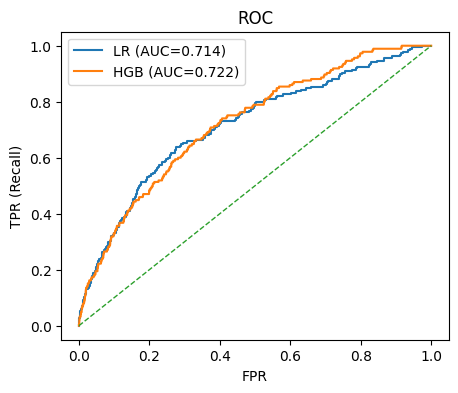

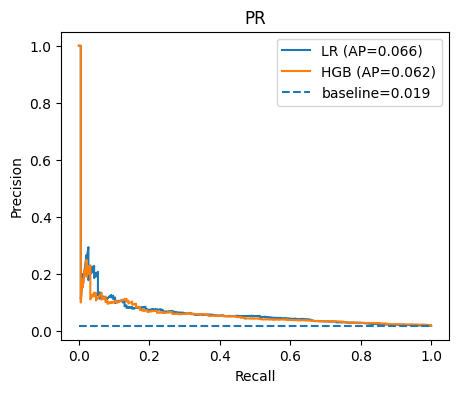

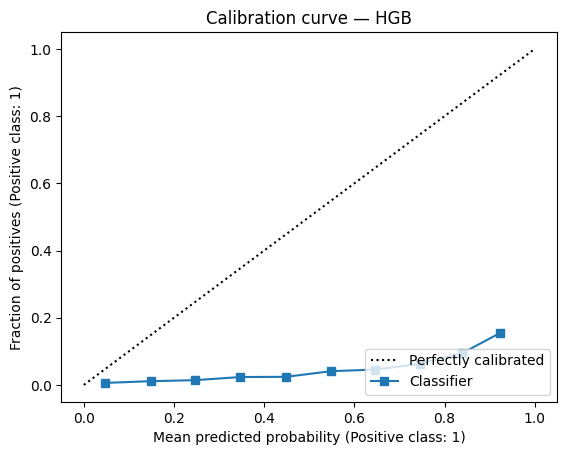

Lift (HGB): {'lift@1%': 6.5199219838395095, 'lift@5%': 3.787668572062822, 'lift@10%': 3.189189189189189}

ROC AUC by slices (HGB):
has_rfm=1: ROC AUC=0.712, n=9101, pos=153
has_rfm=0: ROC AUC=0.612, n=649, pos=32
has_msg=1: ROC AUC=0.734, n=8206, pos=163
has_msg=0: ROC AUC=0.625, n=1544, pos=22


In [47]:
# 1) Предсказания моделей на тесте
proba_lr  = pipe_lr.predict_proba(X_test)[:, 1]
proba_hgb = final.predict_proba(X_test)[:, 1]

# 2) ROC / PR кривые (LR vs HGB)
def plot_roc_pr(y_true, preds_dict):
    plt.figure(figsize=(5,4))
    for name, p in preds_dict.items():
        fpr, tpr, _ = roc_curve(y_true, p)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr,tpr):.3f})")
    plt.plot([0,1],[0,1],'--',lw=1)
    plt.xlabel("FPR"); plt.ylabel("TPR (Recall)"); plt.title("ROC"); plt.legend(); plt.show()

    plt.figure(figsize=(5,4))
    base = y_true.mean()
    for name, p in preds_dict.items():
        prec, rec, _ = precision_recall_curve(y_true, p)
        ap = average_precision_score(y_true, p)
        plt.plot(rec, prec, label=f"{name} (AP={ap:.3f})")
    plt.hlines(base, 0, 1, linestyles='--', label=f"baseline={base:.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR"); plt.legend(); plt.show()

plot_roc_pr(y_test.values, {"LR": proba_lr, "HGB": proba_hgb})

# 3) Калибровка вероятностей HGB
CalibrationDisplay.from_predictions(y_test, proba_hgb, n_bins=10)
plt.title("Calibration curve — HGB")
plt.show()

# 4) Lift@k (как сильно топ-k% превышает базовую долю)
def lift_at_k(y_true, y_proba, ks=(0.01, 0.05, 0.10)):
    base = y_true.mean()
    order = np.argsort(-y_proba)
    res = {}
    for k in ks:
        top = int(len(y_true) * k)
        top_pos = y_true.iloc[order[:top]].mean()
        res[f"lift@{int(k*100)}%"] = float(top_pos / base) if base > 0 else np.nan
    return res

print("Lift (HGB):", lift_at_k(y_test, proba_hgb))

# 5) Срезы качества (has_rfm / has_msg из feature_mart)
meta_test = df['feature_mart'].loc[X_test.index, ['has_rfm','has_msg']].astype(int)

def roc_by_slice(y_true, proba, mask, name):
    s_auc = roc_auc_score(y_true[mask==1], proba[mask==1]) if (mask==1).sum()>0 else np.nan
    n = int((mask==1).sum()); pos = int(y_true[mask==1].sum())
    print(f"{name}=1: ROC AUC={s_auc:.3f}, n={n}, pos={pos}")
    s_auc0 = roc_auc_score(y_true[mask==0], proba[mask==0]) if (mask==0).sum()>0 else np.nan
    n0 = int((mask==0).sum()); pos0 = int(y_true[mask==0].sum())
    print(f"{name}=0: ROC AUC={s_auc0:.3f}, n={n0}, pos={pos0}")

print("\nROC AUC by slices (HGB):")
roc_by_slice(y_test, proba_hgb, meta_test['has_rfm'], "has_rfm")
roc_by_slice(y_test, proba_hgb, meta_test['has_msg'], "has_msg")


## Интерпретация

- **ROC/PR:** HGB чуть лучше по ROC AUC (**0.722** vs **0.714** у LR), но LR выше по PR AUC (**0.066** vs **0.062**). Обе модели заметно лучше базовой линии (AP≈0.019).
- **Калибровка (HGB):** кривая **ниже диагонали** - модель видимо переобучена.
- **Lift:** топ-1% ≈ **6.52×**, топ-5% ≈ **3.79×**, топ-10% ≈ **3.19×** — пригодно для точечных кампаний/приоритизации.
- **Срезы качества (HGB):**
  `has_rfm=1` -  ROC AUC **0.712** vs `has_rfm=0` - **0.612**;
  `has_msg=1` -  ROC AUC **0.734** vs `has_msg=0` - **0.625**.
  Модель лучше работает по клиентам с историей покупок и взаимодействиями с рассылками, а холодный сегмент даётся хуже.


# 14 Финальный тест

In [48]:
# 1) Сравниваем кандидатов по VALID (у нас уже обучены pipe_lr и best_model)
scores_valid = {
    "LR":  roc_auc_score(y_valid, pipe_lr.predict_proba(X_valid)[:, 1]),
    "HGB": roc_auc_score(y_valid, best_model.predict_proba(X_valid)[:, 1]),
}
best_name = max(scores_valid, key=scores_valid.get)
print(f"Choose by valid ROC AUC: {best_name} - {scores_valid}")

# 2) Дообучаем лучшую модель на train+valid
X_trv = pd.concat([X_train, X_valid], axis=0)
y_trv = pd.concat([y_train, y_valid], axis=0)

if best_name == "LR":
    final_model = clone(pipe_lr).fit(X_trv, y_trv)
else:
    # функция make_weights определена на шаге 12
    final_model = clone(final).fit(X_trv, y_trv, sample_weight=make_weights(y_trv))

# 3) Финальные метрики на TEST
proba_test = final_model.predict_proba(X_test)[:, 1]
print("FINAL on TEST:", eval_metrics(y_test, proba_test))

# Дополнительно: lift@1/5/10%
def lift_at_k(y_true, y_proba, ks=(0.01, 0.05, 0.10)):
    base = y_true.mean()
    order = np.argsort(-y_proba)
    res = {}
    for k in ks:
        top = int(len(y_true) * k)
        res[f"lift@{int(k*100)}%"] = float(y_true.iloc[order[:top]].mean() / base) if base>0 else np.nan
    return res

print("FINAL lift:", lift_at_k(y_test, proba_test))

# 4) Сохраняем артефакты
os.makedirs("models", exist_ok=True)
joblib.dump(final_model, "models/final_model.joblib")
with open("models/feature_list.txt", "w", encoding="utf-8") as f:
    f.write("\n".join(X.columns))
with open("models/cfg.json", "w", encoding="utf-8") as f:
    json.dump({
        "model": best_name,
        "T0": str(cfg['T0'].date()),
        "T_max": str(cfg['T_max'].date()),
        "horizon_days": cfg['horizon_days'],
        "n_features": int(X.shape[1])
    }, f, indent=2, ensure_ascii=False)

print("Saved: models/final_model.joblib, models/feature_list.txt, models/cfg.json")


Choose by valid ROC AUC: HGB - {'LR': 0.6970757457583054, 'HGB': 0.700497360597737}
FINAL on TEST: {'roc_auc': 0.7215035108291774, 'pr_auc': 0.06218919002894287, 'logloss': 0.3639108152671597, 'pos_rate': 0.018974358974358976}
FINAL lift: {'lift@1%': 6.5199219838395095, 'lift@5%': 3.787668572062822, 'lift@10%': 3.189189189189189}
Saved: models/final_model.joblib, models/feature_list.txt, models/cfg.json


## Выводы по финальному тесту

- **Выбрана модель:** HGB (по ROC AUC на валидации: 0.700 против 0.697 у LR).
- **Тестовые метрики:** ROC AUC **0.722**, PR AUC **0.062**, LogLoss **0.364** — стабильное обобщение.
- **Lift:** top-1% **6.52×**, top-5% **3.79×**, top-10% **3.19×** — годится для приоритизации кампаний.
- **Артефакты сохранены:** `models/final_model.joblib`, `models/feature_list.txt`, `models/cfg.json`.
